In [227]:
import imageio 
from matplotlib import pyplot as plt
from skimage import data, io
import ipywidgets as widgets
from ipywidgets import Button, Layout
import cv2
from skimage import data, io, filters, exposure
import skimage.morphology as mp
import numpy as np
from skimage.filters import roberts, sobel, scharr, prewitt, frangi, try_all_threshold, threshold_otsu, threshold_local
from skimage import img_as_float
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
import cv2
import numpy as np
from skimage.morphology import disk, dilation, erosion
from scipy.stats import moment
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.patches as mpatches

In [199]:
style = {'description_width': '40%'}

selector = widgets.Dropdown(
    options=[('Test eye 1', ['photos/Image_01L.jpg','photos/Image_01L_1stHO.png']),
             ('Test eye 2', ['photos/Image_02L.jpg','photos/Image_02L_1stHO.png']),
             ('Test eye 3', ['photos/Image_11L.jpg','photos/Image_11L_1stHO.png']),
             ('Test eye 4', ['photos/Image_13L.jpg','photos/Image_13L_1stHO.png']),
             ('Test eye 5', ['photos/Image_08R.jpg','photos/Image_08R_1stHO.png']),
             ('Healthy eye 1', 'photos/01_h.jpg'), ('Healthy eye 2', 'photos/02_h.jpg'),
             ('Healthy eye 3', 'photos/03_h.jpg'), ('Healthy eye 4', 'photos/04_h.jpg'),
            ('Healthy eye 5', 'photos/05_h.jpg'), ('Healthy eye 6', 'photos/06_h.jpg'),
            ('Healthy eye 7', 'photos/07_h.jpg'), ('Healthy eye 8', 'photos/08_h.jpg'), 
            ('Healthy eye 9', 'photos/09_h.jpg'), ('Healthy eye 10', 'photos/010_h.jpg'),
            ('Healthy eye 11', 'photos/011_h.jpg'), ('Healthy eye 12', 'photos/012_h.jpg'), 
            ('Healthy eye 13', 'photos/013_h.jpg'), ('Healthy eye 14', 'photos/014_h.jpg'), 
            ('Healthy eye 15', 'photos/015_h.jpg')],
    value=['photos/Image_01L.jpg','photos/Image_01L_1stHO.png'],
    description='Image:',
    layout=Layout(width='50%', height='30px'),
    style=style
)

display(selector)

Dropdown(description='Image:', layout=Layout(height='30px', width='50%'), options=(('Test eye 1', ['photos/Ima…

In [231]:
#image =cv2.imread(selector.value[0])
def create_mask(image):
    img = rgb2gray(image)
    img[img[:, :] > 0.05] = 1
    img[img[:, :] <= 0.05] = 0
    img = mp.erosion(img, disk(1))
    img = mp.dilation(img, disk(3))
    img = erosion(img, disk(3))
    return img

def image(img):
    mask = create_mask(cv2.imread(img))
    img = cv2.imread(img,0)
    equ = cv2.equalizeHist(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    block_size = 213
    adaptive_thresh = threshold_local(cl1, block_size, offset=10)
    binary_adaptive = cl1 > adaptive_thresh
    binary_adaptive = mp.dilation(mp.dilation(mp.dilation(mp.erosion(binary_adaptive))))
    binary_adaptive[mask == 0 ] = 1
    exit = np.zeros(binary_adaptive.shape)
    exit[binary_adaptive == True] = 0
    exit[binary_adaptive == False] = 1    
    exit = dilation(exit)
    return exit


def confusion_matrix(image, mask):
    result = []
    tp = 0
    fp = 0
    fn = 0
    tn = 0
    for i in range(len(image)):
        row = []
        for j in range(len(image[i])):
            if (image[i][j] == 1.0):
                if (mask[i][j] == 1.0):
                    row.append([0, 255, 0]) #zielony
                    tp+=1
                elif (mask[i][j] == 0.0):
                    row.append([255, 0, 0]) #czerwony
                    fp+=1
            elif (image[i][j] == 0.0):
                if (mask[i][j] == 1.0):
                    row.append([0, 0, 255]) #niebieski
                    fn+=1
                elif (mask[i][j] == 0.0):
                    row.append([255, 255, 255]) #biały
                    tn+=1
        result.append(row)
    return result, tp, fp, fn, tn


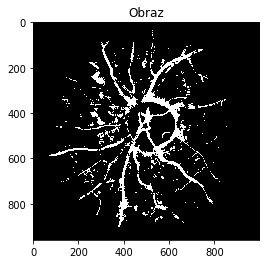

In [253]:
a = image(selector.value[0])
plt.title('Obraz')
plt.imshow(a, cmap = plt.cm.gray)

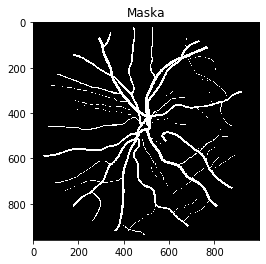

In [254]:
mask = rgb2gray(cv2.imread(selector.value[1]))
plt.title('Maska')
plt.imshow(mask, cmap = plt.cm.gray)

trafność: 0.9319798965632299
czułość: 0.5776631531733573
swoistość: 0.9585430782767569
średnia arytmetyczna czułości i swoistości: 0.7681031157250571


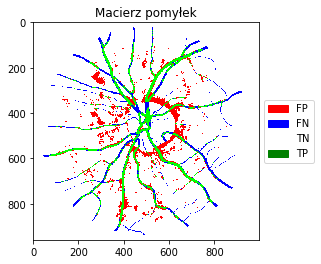

In [256]:
res, tp, fp, fn, tn = confusion_matrix(a, mask)

#czułość
tpr = tp / (tp + fn)
#trafność
ppv = (tp + tn) / (tn + fn + tp + fp)
#swoistość
spc = tn / (fp + tn)

avg = (spc + tpr) / 2
print("trafność:", ppv)
print("czułość:", tpr)
print("swoistość:", spc)
print("średnia arytmetyczna czułości i swoistości:", avg)
plt.title('Macierz pomyłek')
red_patch = mpatches.Patch(color='red', label='FP')
blue_patch = mpatches.Patch(color='blue', label='FN')
white_patch = mpatches.Patch(color='white', label='TN')
green_patch = mpatches.Patch(color='green', label='TP')
plt.legend(handles=[red_patch, blue_patch,white_patch, green_patch], loc='center left', bbox_to_anchor=(1, 0.5))
plt.imshow(res)

In [121]:
def get_features(img):
    cen_moments_2 = []
    cen_moments_3 = []
    cen_moments_4 = []
    cen_moments_5 = []
    #img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for i in range(len(img)//5):
        for j in range(len(img[0])//5):
            part_img = img [5*i:5*(i+1), 5*j:5*(j+1)].flatten()
            cen_moments_2.append(moment(part_img, moment = 2))
            cen_moments_3.append(moment(part_img, moment = 3))
            cen_moments_4.append(moment(part_img, moment = 4))
            cen_moments_5.append(moment(part_img, moment = 5))
    return cen_moments_2, cen_moments_3,  cen_moments_4,  cen_moments_5

def get_labels(img):
    label = [] 
    for i in range(len(img)//5):
        for j in range(len(img[0])//5):
            label.append(img[i+2][j+2])
    return label

def create_klas(img1, hand, klasyfikator):
    c,d,e,f  = get_features(img)
    X = pd.DataFrame({"c": c, "d": d, "e":e, "f":f})
    y = get_labels(cv2.imread(hand))
    klasyfikator.fit(X = X, y = y)
    return klasyfikator

def prepare(img):
    c,d,e,f  = get_features(img)
    X = pd.DataFrame({"c": c, "d": d, "e":e, "f" :f})
    return X



In [122]:
klasyfikator = DecisionTreeClassifier(criterion = "entropy")
klasyfikator = create_klas (image('photos/Image_03L.jpg'),'photos/Image_03L_1stHO.png', klasyfikator)

In [123]:
predicted = klasyfikator.predict(prepare(image(selector.value[0])))

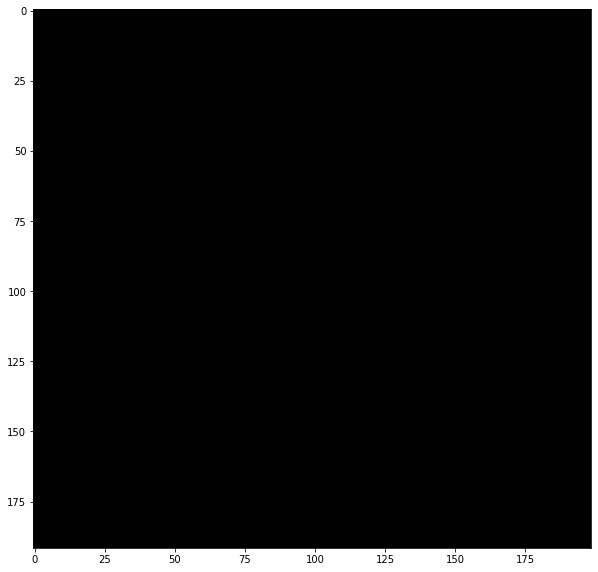

In [124]:
x, y = cv2.imread(selector.value[0],0).shape
predicted = np.array_split(predicted, x//5)
plt.figure(figsize=(10, 10))
plt.imshow(predicted, cmap=plt.cm.gray)